In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
# import matplotlib as mpl
# mpl.use('Agg')
# from matplotlib.animation import FFMpegWriter
from tqdm import tqdm
from pprint import pprint

In [2]:
DEFAULT_TONEMAP_PARAMS = {"policy": "tonemap", "alpha": 0.25, "beta": 0.9, "gamma": 0.9, "eps": 1e-6}
def normalize_image(image, hdr_mode=True, normalization_params=DEFAULT_TONEMAP_PARAMS, return_8_bit=False):
    """
    Normalize an 8 bit image according to the specified policy.
    If return_8_bit, this returns an np.uint8 image, otherwise it returns a floating point
    image with values in [0, 1].
    """
    normalization_policy = normalization_params['policy']
    lower_bound = 0
    upper_bound = 1
    if np.isnan(hdr_mode):
        hdr_mode = False

    if hdr_mode and image.dtype == np.uint8:
        # The image was normalized during pack-perception (tonemap)
        if return_8_bit:
            return image
        lower_bound = 0.0
        upper_bound = 255.0
    elif normalization_policy == "percentile" and hdr_mode:
        lower_bound = np.array([np.percentile(image[..., i],
                                              normalization_params['lower_bound'],
                                              interpolation='lower')
                                for i in range(3)])
        upper_bound = np.array([np.percentile(image[..., i],
                                              normalization_params['upper_bound'],
                                              interpolation='lower')
                                for i in range(3)])
    elif normalization_policy == "percentile_vpu" and hdr_mode:
        r, g, b = image[..., 0], image[..., 1], image[..., 2]
        brightness = (3 * r + b + 4 * g) / 8
        lower_bound = np.percentile(brightness, normalization_params['lower_bound'],
                                    interpolation='lower')
        upper_bound = np.percentile(brightness, normalization_params['upper_bound'],
                                    interpolation='lower')
    elif normalization_policy == "3sigma" and hdr_mode:
        sigma_size = normalization_params['sigma_size']
        min_variance = normalization_params['min_variance']
        r, g, b = image[..., 0], image[..., 1], image[..., 2]
        brightness = (3 * r + b + 4 * g) / 8
        mean, sigma = np.mean(brightness), np.std(brightness)
        brightness_min, brightness_max = np.min(brightness), np.max(brightness)
        if (sigma * sigma_size) > mean:
            lmin = brightness_min
            lmax = min(brightness_max, mean * sigma_size)
            if (lmax - lmin) < min_variance:
                lmax = lmin + min_variance
            lower_bound = lmin
            upper_bound = lmax
        else:
            mean_var = mean - sigma_size * sigma
            output_min = max(brightness_min, mean_var)
            mean_var = mean + sigma_size * sigma
            output_max = min(brightness_max, mean_var)
            if (output_max - output_min) < min_variance:
                output_min = mean - min_variance / 2.0
                output_min = 0 if output_min < 0 else output_min
                output_max = output_min + min_variance
            lower_bound = output_min
            upper_bound = output_max
    elif normalization_policy == 'tonemap' and hdr_mode:
        if image.dtype != np.float32 and image.dtype != np.uint32:
            raise ValueError('HDR image type is {} instead of float32 or uint32'.format(image.dtype))
        alpha = normalization_params.get('alpha', DEFAULT_TONEMAP_PARAMS['alpha'])
        beta = normalization_params.get('beta', DEFAULT_TONEMAP_PARAMS['beta'])
        gamma = normalization_params.get('gamma', DEFAULT_TONEMAP_PARAMS['gamma'])
        eps = normalization_params.get('eps', DEFAULT_TONEMAP_PARAMS['eps'])

        r, g, b = image[..., 0], image[..., 1], image[..., 2]
        lum_in = 0.2126 * r + 0.7152 * g + 0.0722 * b
        lum_norm = np.exp(gamma * np.mean(np.log(lum_in + eps)))
        c = alpha * lum_in / lum_norm
        c_max = beta * np.max(c)
        lum_out = c / (1 + c) * (1 + c / (c_max ** 2))
        image = image * (lum_out / (lum_in + eps))[..., None]
    elif normalization_policy == "none" and hdr_mode:
        lower_bound = 0.0
        upper_bound = 2**20 - 1
    elif normalization_policy == "default" or not hdr_mode:
        assert np.max(image) <= 255 and np.min(image) >= 0, "Image with default " \
            "mode should be in range [0,255]"
        lower_bound = 0.0
        upper_bound = 255.0
    else:
        raise ValueError(
            f"--normalization-policy '{normalization_policy}' is not supported! "
            f"(on image with hdr_mode={hdr_mode})")

    image = (image.astype(np.float32, copy=False) - lower_bound) / (upper_bound - lower_bound)

    if return_8_bit:
        image = np.clip(image * 255.0, 0.0, 255.0)
        image = np.uint8(image)
    else:
        image = np.clip(image, 0.0, 1.0)

    return image

def read_saved_frame(pred_dir, image_id):
    states_to_save = ['', 'false_positive', 'false_negative', 'large_object_false_negative', 'true_positive', 'true_negative']
    frame = None
    for state in states_to_save:
        if os.path.isfile(os.path.join(pred_dir, state, image_id+'.png')):
            frame = cv2.imread(os.path.join(pred_dir, state, image_id+'.png'))
            break
        if os.path.isfile(os.path.join(pred_dir, state, image_id+'.jpg')):
            frame = cv2.imread(os.path.join(pred_dir, state, image_id+'.jpg'))
            break
    return frame


def get_bbox_coords(i=-1, bbox_range_list=[], bbox_coord_list=[]):
    for bi in range(len(bbox_range_list)):
        bbox_range = bbox_range_list[bi]
        if bbox_range[0] <= i <= bbox_range[1]:
            return bbox_coord_list[bi]
    return []

def read_raw_image(data_dir, _id):
    image_path = os.path.join(data_dir, 'images', _id, 'artifact_debayeredrgb_0_'+_id+'.png')
    image = cv2.imread(image_path)
    return image
    
from datetime import datetime, timedelta

def get_sequences(df, interval=5*60, per_camera=False):
    df = df.sort_values('collected_on')
    df['datetime'] = df.collected_on.apply(datetime.fromisoformat)
    sequence_dfs = []
    delta = timedelta(seconds=interval)
    start = True
    i0, i = 0, 0
    while i < len(df):
        if start:
            t0 = df.iloc[i].datetime
            start = False
        else:
            t1 = df.iloc[i].datetime
            if t1 - t0 > delta or i == len(df) - 1:
                chunk_df = df.iloc[i0 : i if i < len(df) - 1 else len(df)]
                if per_camera:
                    camera_locations = chunk_df.camera_location.unique()
                    camera_locations.sort()
                    for camera_location in camera_locations:
                        sequence_df = chunk_df[chunk_df.camera_location == camera_location]
                        sequence_df = sequence_df.sort_values('collected_on')
                        sequence_dfs.append(sequence_df)
                else:
                    sequence_dfs.append(chunk_df)
                start = True
                i0 = i
            else:
                t0 = t1
        i += 1
    return sequence_dfs

### Read and merge dfs

In [3]:
def merge_meta_with_pred(master_df, label_df, unlabeled_pred_df, labeled_pred_df):
    print('master_df', master_df.shape)
    df = master_df[['id', 'collected_on', 'camera_location', 'operation_time', 'geohash']]
    
    # merge with label_df
    df = df.merge(label_df, on='id', how='left')
    df = df.fillna(0)
    print('merge label counts', df.shape)

    # load prediction on unlabeled data to get dust ratios
    print('unlabeled_pred_df', unlabeled_pred_df.shape)
    if not 'total_averaged_dust_ratio' in unlabeled_pred_df:
        unlabeled_pred_df['total_averaged_dust_ratio'] = unlabeled_pred_df['total_averaged_dust_conf']
        unlabeled_pred_df['triangle_averaged_dust_ratio'] = unlabeled_pred_df['masked_avg_dust_conf']
    df = df.merge(unlabeled_pred_df[['id', 'total_averaged_dust_ratio', 'triangle_averaged_dust_ratio']], on='id')
    print('merge unlabeled dust ratios', df.shape)

    # load prediction on labeled data to get the prediction "state"
    print('labeled_pred_df', labeled_pred_df.shape)
    # convert LO states to regular states and fill empty states with TNs
    df = df.merge(labeled_pred_df[['id', 'state']], on='id', how='left').drop_duplicates(subset=['id'])
    df = df.fillna('true_negative')
    df = df.replace('large_object_true_positive', 'true_positive')
    df = df.replace('large_object_false_negative', 'false_negative')
    print('merge labeled states', df.shape)

    # sort by time and add datetime column
    df = df.sort_values('collected_on')
    df['datetime'] = df.collected_on.apply(datetime.fromisoformat)
    df['datehm'] = df.collected_on.apply(lambda x:str(x)[:16])
    print('final_df', df.shape)
    print('# TPs', len(df[df.state == 'true_positive']), '# Positives', len(df[(df.state == 'true_positive') | (df.state == 'false_negative')]))
    
    return df

def plot_dust_ratio_and_state(seq_df, save_path, title='', labeled_states=False, plot_entire_image=True, plot_masked_region=False):
    seq_df['datetime'] -= seq_df.iloc[0]['datetime']
    plt.figure(1, figsize=(20, 5))
    if plot_entire_image and plot_masked_region:
        plt.subplot(121)
    states = {'true_negative': ['TN', 'blue'], 'false_positive': ['FP', 'orange']}
    if labeled_states:
        states['false_negative'] = ['FN', 'red']
        states['true_positive'] = ['TP', 'green']
    if plot_entire_image:
        for state, [label, color] in states.items():
            sub_df = seq_df[seq_df.state == state]
            if len(sub_df) > 0:
                plt.scatter(sub_df.datetime.apply(lambda x: x.total_seconds()), sub_df.total_averaged_dust_ratio, label=label, c=color)
        plt.title(seq_df.iloc[0].collected_on if len(title) == 0 else title, fontsize=15)
        plt.xlabel('Time in sequence (s)', fontsize=15)
        plt.ylabel('Dust ratio in entire image', fontsize=15)
        plt.legend()
    if plot_entire_image and plot_masked_region:
        plt.subplot(122)
    if plot_masked_region:
        for state, [label, color] in states.items():
            sub_df = seq_df[seq_df.state == state]
            if len(sub_df) > 0:
                plt.scatter(sub_df.datetime.apply(lambda x: x.total_seconds()), sub_df.triangle_averaged_dust_ratio, label=label, c=color)
        plt.title(seq_df.iloc[0].collected_on if len(title) == 0 else title, fontsize=15)
        plt.xlabel('Time in sequence (s)', fontsize=15)
        plt.ylabel('Dust ratio in triangles', fontsize=15)
        plt.legend()
    # plt.show()
    plt.savefig(save_path)
    plt.close()

def read_from_pp_artifacts(data_dir, df_row):
    data_path = os.path.join(data_dir, 'processed/images', df_row.id, 'stereo_output.npz')
    img = np.load(data_path)['left']
    img_norm = normalize_image(img, df_row.hdr_mode if 'hdr_mode' in df_row else True)
    return (img_norm * 255).astype(np.uint8)

def add_text(frame, txt_row):
    frame = cv2.putText(frame, f'Collected on: {txt_row.collected_on}', 
                        (40,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    return frame

In [4]:
data_root_dir = '/data/jupiter/li.yu/data'
unlabeled_datasets = ["Jupiter_2023_03_29_10pm_30_3pm_Loamy_812_stops_stereo_2", 
                      "Jupiter_2023_04_05_loamy869_dust_collection_stereo", 
                      "Jupiter_2023_may_loamy731_vehicle_dust_human_stereo"]
labeled_datasets = ["Jupiter_2023_03_02_and_2930_human_vehicle_in_dust_labeled", 
                    "Jupiter_2023_March_29th30th_human_vehicle_in_dust_front_pod_labeled", 
                    "Jupiter_2023_04_05_loamy869_dust_collection_stereo_labeled", 
                    "Jupiter_2023_may_loamy731_vehicle_dust_human_stereo_labeled"]
pred_root = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
train_id = 'v57rd_4cls_tiny0occluded5reverse5triangle5_msml_0305'

In [5]:
# set 1
i = 0
master_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[i], 'master_annotations.csv'), low_memory=False)
label_df1 = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[i], 'label_count.csv'))
label_df2 = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[i+1], 'label_count.csv'))
label_df = pd.concat([label_df1, label_df2], ignore_index=True)
unlabeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, unlabeled_datasets[i]+'_epoch43_newmask', 'dust_ratio.csv'))
labeled_pred_df1 = pd.read_csv(os.path.join(pred_root, train_id, labeled_datasets[i]+'_epoch43', 'output.csv'))
labeled_pred_df2 = pd.read_csv(os.path.join(pred_root, train_id, labeled_datasets[i+1]+'_epoch43', 'output.csv'))
labeled_pred_df = pd.concat([labeled_pred_df1, labeled_pred_df2], ignore_index=True)
df1 = merge_meta_with_pred(master_df, label_df, unlabeled_pred_df, labeled_pred_df)

# set 2
i = 1
master_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[i], 'master_annotations.csv'), low_memory=False)
label_df = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[i+1], 'label_count.csv'))
unlabeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, unlabeled_datasets[i]+'_epoch43', 'dust_ratio.csv'))
labeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, labeled_datasets[i+1]+'_epoch43', 'output.csv'))
df2 = merge_meta_with_pred(master_df, label_df, unlabeled_pred_df, labeled_pred_df)

# set 3
i = 2
master_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[i], 'master_annotations.csv'), low_memory=False)
label_df = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[i+1], 'label_count.csv'))
unlabeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, unlabeled_datasets[i]+'_epoch43', 'dust_ratio.csv'))
labeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, labeled_datasets[i+1]+'_epoch43', 'output.csv'))
df3 = merge_meta_with_pred(master_df, label_df, unlabeled_pred_df, labeled_pred_df)

df = pd.concat([df1, df2, df3], ignore_index=True)
print('merge all three sets (double df3 as it is halved) to get df', df.shape)
pdf = df[(df.state == 'true_positive') | (df.state == 'false_negative')]
print('positive images', pdf.shape)

# df = df2
dfs = [df1, df2, df3]

master_df (36206, 127)
merge label counts (36206, 11)
unlabeled_pred_df (36206, 5)
merge unlabeled dust ratios (36206, 13)
labeled_pred_df (8359, 10)
merge labeled states (36206, 14)
final_df (36206, 16)
# TPs 2346 # Positives 3701
master_df (27374, 138)
merge label counts (27374, 11)
unlabeled_pred_df (27374, 9)
merge unlabeled dust ratios (27374, 13)
labeled_pred_df (5918, 10)
merge labeled states (27374, 14)
final_df (27374, 16)
# TPs 1770 # Positives 2368
master_df (29999, 138)
merge label counts (29999, 11)
unlabeled_pred_df (29999, 9)
merge unlabeled dust ratios (29999, 13)
labeled_pred_df (6717, 10)
merge labeled states (29999, 14)
final_df (29999, 16)
# TPs 3177 # Positives 3543
merge all three sets (double df3 as it is halved) to get df (93579, 16)
positive images (9612, 16)


### Get vehicle type and color meta info

In [6]:
vehicle_meta_csv = './Vehicle in dust data collected in Spring 2023 - Data collection.csv'
vehicle_meta_df = pd.read_csv(vehicle_meta_csv)
vehicle_meta_df = vehicle_meta_df.fillna('')
print(vehicle_meta_df.shape)
vehicle_meta_df = vehicle_meta_df.drop(vehicle_meta_df[vehicle_meta_df['Notes'] == 'do not use'].index)
print(vehicle_meta_df.shape)
vehicle_meta_df.head()

(171, 8)
(169, 8)


,Collection set,Camera Pod,Video ID,Time,Vehicle type,Vehicle color,Human pose,Notes
0,March 29th and 30th,Rear,7,Day,Pickup,white,,
1,March 29th and 30th,Front,7,Day,Pickup,white,,
2,March 29th and 30th,Rear,8,Day,Pickup,white,,
3,March 29th and 30th,Rear,9,Day,Pickup,white,,
4,March 29th and 30th,Front,9,Day,Pickup,white,,


In [7]:
vehicle_meta_df['geohashs'] = ''
vehicle_meta_df['overall_dust_level'] = -1.0
vehicle_meta_df['with_vehicle_dust_level'] = -1.0
vehicle_meta_df['vehicle_frame_count'] = 0
vehicle_meta_df['vehicle_frame_duration'] = 0  # in seconds
# vehicle_meta_df['seq_df'] = ''

In [8]:
collection_sets = ['March 29th and 30th', 'April 5th', 'Apri 27th, May 1st and 4th']
for di, df in enumerate(dfs):
    df['used_in_video_id'] = -1
    selected_runs_ids = []
    for pod in ['Front', 'Rear']:
        if pod == 'Front':
            sub_df = df[df.camera_location.str.startswith('front')]
            cameras = ['front-left-left', 'front-center-left', 'front-right-left']
        else:
            sub_df = df[~df.camera_location.str.startswith('front')]
            cameras = ['side-left-left', 'rear-left', 'side-right-left']
        seq_dfs = get_sequences(sub_df, interval=10, per_camera=False)
        print(di, pod, len(seq_dfs), 'sequences')

        for si, seq_df in enumerate(seq_dfs):
            seq_pdf = seq_df[(seq_df.state == 'true_positive') | (seq_df.state == 'false_negative')]
            if len(seq_pdf) <= 2:
                continue
            tmp_df = vehicle_meta_df[(vehicle_meta_df['Collection set'] == collection_sets[di]) & 
                                     (vehicle_meta_df['Camera Pod'] == pod) & 
                                     (vehicle_meta_df['Video ID'] == si)]
            if len(tmp_df) > 0:
                geohashs = '+'.join(list(seq_pdf.geohash.unique()))
                overall_dust_level = seq_df.total_averaged_dust_ratio.mean()
                with_vehicle_dust_level = seq_pdf.total_averaged_dust_ratio.mean()
                vehicle_frame_count = len(seq_pdf)
                vehicle_frame_duration = (seq_pdf.iloc[-1].datetime - seq_pdf.iloc[0].datetime).total_seconds()
                if tmp_df.iloc[0].Notes == 'first half stationary':
                    seq_df = seq_df.tail(n=len(seq_df)//2)
                elif tmp_df.iloc[0].Notes == 'first two thirds stationary':
                    seq_df = seq_df.tail(n=len(seq_df)//3)
                vehicle_meta_df.loc[(vehicle_meta_df['Collection set'] == collection_sets[di]) & 
                                     (vehicle_meta_df['Camera Pod'] == pod) & 
                                     (vehicle_meta_df['Video ID'] == si), 
                                    ['geohashs', 'overall_dust_level', 'with_vehicle_dust_level', 
                                     'vehicle_frame_count', 'vehicle_frame_duration']] = [geohashs, overall_dust_level, 
                                                                                                    with_vehicle_dust_level, 
                                                                                                    vehicle_frame_count, 
                                                                                                    vehicle_frame_duration]
                if vehicle_frame_duration >= 5 and vehicle_meta_df[(vehicle_meta_df['Collection set'] == collection_sets[di]) & 
                                     (vehicle_meta_df['Camera Pod'] == pod) & 
                                     (vehicle_meta_df['Video ID'] == si)].iloc[0]['Vehicle type'] != 'Human':
                    df.loc[df.id.isin(seq_pdf.id), 'used_in_video_id'] = si
    #             break
    #     break
    # break

def get_dust_level(r):
    dust_level = 'heavy dust'
    if r.with_vehicle_dust_level <= 0.15:
        dust_level = 'low dust'
    elif r.with_vehicle_dust_level <= 0.25:
        dust_level = 'medium dust'
    return dust_level

vehicle_meta_df['Dust level'] = vehicle_meta_df.apply(lambda r: get_dust_level(r), axis=1)
# vehicle_meta_df.to_csv('./Vehicle in dust data collected in Spring 2023 - Data collection expanded.csv', index=False)
print(vehicle_meta_df.shape)
vehicle_meta_df.head()

0 Front 103 sequences
0 Rear 83 sequences
1 Front 51 sequences
1 Rear 43 sequences
2 Front 26 sequences
2 Rear 28 sequences
(169, 14)


,Collection set,Camera Pod,Video ID,Time,Vehicle type,Vehicle color,Human pose,Notes,geohashs,overall_dust_level,with_vehicle_dust_level,vehicle_frame_count,vehicle_frame_duration,Dust level
0,March 29th and 30th,Rear,7,Day,Pickup,white,,,7zzzzzzzzzzz,0.108089,0.154131,141,29.934,medium dust
1,March 29th and 30th,Front,7,Day,Pickup,white,,,9zpbb4z12uz8+9zpbb4z131bu+9zpbb4z1303w+9zpbb4z...,0.008265,0.037799,16,5.302,low dust
2,March 29th and 30th,Rear,8,Day,Pickup,white,,,7zzzzzzzzzzz,0.141331,0.205114,150,27.731,medium dust
3,March 29th and 30th,Rear,9,Day,Pickup,white,,,7zzzzzzzzzzz,0.112522,0.143278,127,26.432,low dust
4,March 29th and 30th,Front,9,Day,Pickup,white,,,9zpbb4ycwmw9+9zpbb4ycwkp7+9zpbb4ycw90x+9zpbb4y...,0.005474,0.008023,5,1.309,low dust


In [9]:
# plot_dust_ratio_and_state(sub_df.head(n=len(sub_df)), save_path=f'./dust_batch{i+1}_{pod}.png', 
#                         title=f'{pod} pod', labeled_states=True, plot_entire_image=True, plot_masked_region=False)

useful_df = vehicle_meta_df[(vehicle_meta_df['Collection set'] == 'Apri 27th, May 1st and 4th') & (vehicle_meta_df['Camera Pod'] == 'Rear') & (vehicle_meta_df['Vehicle type'] != 'Human')]
# useful_df = vehicle_meta_df[(vehicle_meta_df.vehicle_frame_duration >= 5) & (vehicle_meta_df['Camera Pod'] == 'Rear') & (vehicle_meta_df['Vehicle type'] != 'Human')]
print(len(vehicle_meta_df), len(useful_df))
useful_df.groupby(['Camera Pod', 'Time', 'Vehicle type', 'Vehicle color', 'Dust level']).count()

169 22


Collection set  \
Camera Pod Time  Vehicle type Vehicle color Dust level                   
Rear       Day   Pickup       white         low dust                 9   
           Dusk  Pickup       black         low dust                 6   
           Night Pickup       black         low dust                 7   

                                                        Video ID  Human pose  \
Camera Pod Time  Vehicle type Vehicle color Dust level                         
Rear       Day   Pickup       white         low dust           9           9   
           Dusk  Pickup       black         low dust           6           6   
           Night Pickup       black         low dust           7           7   

                                                        Notes  geohashs  \
Camera Pod Time  Vehicle type Vehicle color Dust level                    
Rear       Day   Pickup       white         low dust        9         9   
           Dusk  Pickup       black         low dust        6         6   
           Night Pickup       black         low dust        7         7   

                                                        overall_dust_level  \
Camera Pod Time  Vehicle type Vehicle color Dust level                       
Rear       Day   Pickup       white         low dust                     9   
           Dusk  Pickup       black         low dust                     6   
           Night Pickup       black         low dust                     7   

                                                        with_vehicle_dust_level  \
Camera Pod Time  Vehicle type Vehicle color Dust level                            
Rear       Day   Pickup       white         low dust                          9   
           Dusk  Pickup       black         low dust                          6   
           Night Pickup       black         low dust                          7   

                                                        vehicle_frame_count  \
Camera Pod Time  Vehicle type Vehicle color Dust level                        
Rear       Day   Pickup       white         low dust                      9   
           Dusk  Pickup       black         low dust                      6   
           Night Pickup       black         low dust                      7   

                                                        vehicle_frame_duration  
Camera Pod Time  Vehicle type Vehicle color Dust level                          
Rear       Day   Pickup       white         low dust                         9  
           Dusk  Pickup       black         low dust                         6  
           Night Pickup       black         low dust                         7

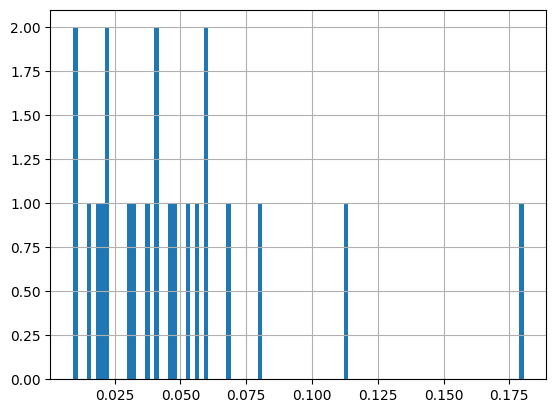

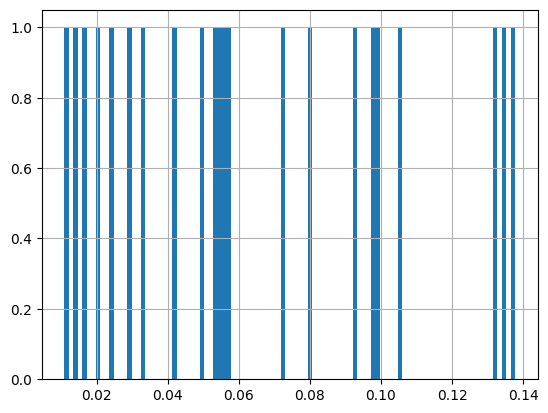

In [10]:
useful_df.overall_dust_level.hist(bins=100)
plt.show()
useful_df.with_vehicle_dust_level.hist(bins=100)
plt.show()

### Split data by geohash

In [11]:
import random
from geolib import geohash
import folium
import geopandas as gpd
from shapely.geometry import Polygon

ModuleNotFoundError: No module named 'geolib'

In [12]:
# assign geohash of front cameras to rear cameras
df = df1
df['geohash_9'] = df.geohash.str[:9]
front_df, rear_df = df[df.camera_location.str.startswith('front')], df[~df.camera_location.str.startswith('front')]
delta = timedelta(seconds=0.5)
for i,row in rear_df.iterrows():
    same_window_df = front_df[((front_df.datetime - row.datetime) < delta) & (front_df.datetime - row.datetime > -delta)]
    if len(same_window_df) >= 1:
        rear_df.loc[i, 'geohash_9'] = same_window_df.iloc[0].geohash_9
    # elif len(same_window_df) > 1:
    #     same_window_df['time_delta'] = same_window_df.datetime - row.datetime
    #     same_window_df['time_delta'] = same_window_df.time_delta.apply(lambda x: abs(x.total_seconds()))
    #     si = same_window_df['time_delta'].idxmin()  # index in original df
    #     # print(same_window_df['time_delta'])
    #     # print(si)
    #     rear_df.loc[i, 'geohash_9'] = df.iloc[si].geohash_9
print(front_df.shape, rear_df.shape, rear_df[rear_df.geohash_9 != '7zzzzzzzz'].shape)

/home/alex.li/.conda/envs/cvml/lib/python3.10/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(17978, 18) (18228, 18) (15957, 18)


In [13]:
# Camera_pod = 'Rear'
# Collection_set = 'Apri 27th, May 1st and 4th'
# video_df = vehicle_meta_df[(vehicle_meta_df['Collection set'] == Collection_set) & (vehicle_meta_df['Camera Pod'] == Camera_pod) 
#     & (vehicle_meta_df['Vehicle type'] != 'Human')]
# video_ids = video_df['Video ID'].to_list()

# train_set = []
# Times = ['Day', 'Dusk', 'Night']
# for Time in Times:
#     car_video_ids = vehicle_meta_df[(vehicle_meta_df['Collection set'] == Collection_set) & (vehicle_meta_df['Time'] == Time) 
#         & (vehicle_meta_df['Camera Pod'] == Camera_pod)
#         & ((vehicle_meta_df['Vehicle type'] == 'Midsized SUV') | (vehicle_meta_df['Vehicle type'] == 'Pickup'))]['Video ID'].to_list()
#     car_train_set = random.sample(car_video_ids, k=len(car_video_ids)//2)
#     train_set += car_train_set
#     print(f'{Time} - select {len(car_train_set)} SUV/Pickup runs out of {len(car_video_ids)}: {car_train_set} in {car_video_ids}')
    
#     ranger_video_ids = vehicle_meta_df[(vehicle_meta_df['Collection set'] == Collection_set) & (vehicle_meta_df['Time'] == Time) 
#         & (vehicle_meta_df['Camera Pod'] == Camera_pod)
#         & (vehicle_meta_df['Vehicle type'] == 'Range (gator)')]['Video ID'].to_list()
#     ranger_train_set = random.sample(ranger_video_ids, k=len(ranger_video_ids)//2)
#     train_set += ranger_train_set
#     print(f'{Time} - select {len(ranger_train_set)} ranger runs out of {len(ranger_video_ids)}: {ranger_train_set} in {ranger_video_ids}')

train_set, video_ids = [8, 13, 14, 9, 25, 31, 23, 26, 28, 27, 54, 56, 49, 50, 60, 58], [47, 48, 49, 50, 51, 53, 54, 55, 56, 58, 59, 60, 61]

print(len(train_set), len(video_ids))
print(train_set, 'in', video_ids)

16 13
[8, 13, 14, 9, 25, 31, 23, 26, 28, 27, 54, 56, 49, 50, 60, 58] in [47, 48, 49, 50, 51, 53, 54, 55, 56, 58, 59, 60, 61]


In [14]:
# useful_df = rear_df[(rear_df.used_in_video_id >= 0) & (rear_df.geohash_9 != '7zzzzzzzz')]
useful_df = rear_df[(rear_df.used_in_video_id.isin(video_ids)) & (rear_df.geohash_9 != '7zzzzzzzz')]
print(df.shape, rear_df.shape, useful_df.shape)
useful_df.groupby('geohash_9').agg({'id':'count'})

(36206, 18) (18228, 18) (940, 18)


,id
geohash_9,
9zpbb69j7,5
9zpbb69je,8
9zpbb69jx,4
9zpbb69jz,2
9zpbb69m0,1
...,...
9zpbb718e,2
9zpbb718g,4
9zpbb7195,2


In [16]:
def video_ids(x):
    return set(x)
    # return '+'.join([str(i) for i in set(x)])
# hash_gp = useful_df.groupby('geohash_9').agg({'geohash':'count'})
hash_gp = useful_df.groupby('geohash_9').agg({'geohash':'count', 'used_in_video_id': [video_ids], 'total_averaged_dust_ratio': 'mean'})

# hash_gp.rename(columns={"geohash": "geohash_count"}, inplace = True)
# hash_gp['percentage'] = (hash_gp['geohash_count'] / sum(hash_gp['geohash_count'])) * 100
hash_gp['percentage'] = (hash_gp[('geohash', 'count')] / sum(hash_gp[('geohash', 'count')])) * 100
hash_gp.reset_index(level=0, inplace=True)
hash_gp['bounds'] =  [geohash.bounds(geo) for geo in hash_gp['geohash_9']]
hash_gp['polygon_geom'] = [Polygon(zip([bounds.sw.lon, bounds.ne.lon, bounds.ne.lon, bounds.sw.lon],
                                       [bounds.ne.lat, bounds.ne.lat, bounds.sw.lat, bounds.sw.lat])) 
                           for bounds in hash_gp['bounds']]
crs = {'init': 'epsg:4326'}
polygon_df = gpd.GeoDataFrame(hash_gp, crs=crs, geometry= hash_gp['polygon_geom'])
print(useful_df.shape, polygon_df.shape)
polygon_df.head()

NameError: name 'geohash' is not defined

In [188]:
m = folium.Map([39.52151298522949, -90.34216403961182], zoom_start=15)
for _, r in polygon_df.iterrows():
    if len(r[('used_in_video_id', 'video_ids')].intersection(train_set)) > 0:
        sim_geo = gpd.GeoSeries(r['geometry'])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data= geo_j,
                            style_function=lambda x: {'fillColor': 'red', 'color': 'red'})
        # percent = round(r['percentage'],2)
        folium.Popup('geohash_9: {}, percentage {}'.format(r['geohash_9'], r['percentage'])).add_to(geo_j)
        folium.Tooltip('video ids {}, mean dust {:.2f}'.format(r[('used_in_video_id', 'video_ids')], r[('total_averaged_dust_ratio', 'mean')])).add_to(geo_j)
        geo_j.add_to(m)

for _, r in polygon_df.iterrows():
    if len(r[('used_in_video_id', 'video_ids')].intersection(train_set)) == 0:
        sim_geo = gpd.GeoSeries(r['geometry'])
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data= geo_j,
                            style_function=lambda x: {'fillColor': 'blue', 'color': 'blue'})
        # percent = round(r['percentage'],2)
        folium.Popup('geohash_9: {}, percentage {}'.format(r['geohash_9'], r['percentage'])).add_to(geo_j)
        folium.Tooltip('video ids {}, mean dust {:.2f}'.format(r[('used_in_video_id', 'video_ids')], r[('total_averaged_dust_ratio', 'mean')])).add_to(geo_j)
        geo_j.add_to(m)

# folium.LatLngPopup().add_to(m)
# folium.features.GeoJsonPopup(fields=row['geohash_count'],labels=False ).add_to(m)

folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Esri Satellite',
        overlay=False,
        control=True
    ).add_to(m)
m

### Check training and testing distributions

In [17]:
useful_df = vehicle_meta_df[(vehicle_meta_df['Camera Pod'] == 'Rear') & (vehicle_meta_df['Vehicle type'] != 'Human')]
useful_df['Vehicle type 2'] = useful_df['Vehicle type'].apply(lambda x: 'SUV or Pickup' if x != 'Range (gator)' else x)
useful_df['Vehicle color 2'] = useful_df['Vehicle color'].apply(lambda x: 'black or gray' if x == 'black' or x == 'gray' else x)
print(len(vehicle_meta_df), len(useful_df))

169 70


/tmp/ipykernel_87864/2134139611.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_df['Vehicle type 2'] = useful_df['Vehicle type'].apply(lambda x: 'SUV or Pickup' if x != 'Range (gator)' else x)
/tmp/ipykernel_87864/2134139611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_df['Vehicle color 2'] = useful_df['Vehicle color'].apply(lambda x: 'black or gray' if x == 'black' or x == 'gray' else x)


In [18]:
Collection_sets = ['March 29th and 30th', 'April 5th', 'Apri 27th, May 1st and 4th']
rear_train_sets = [[8, 13, 14, 9, 25, 31, 23, 26, 28, 27, 54, 56, 49, 50, 60, 58], [17, 11, 14, 15, 1, 6, 4], [5, 8, 1, 0, 12, 15, 17, 25, 26, 19]]
useful_df['for_training'] = False
useful_df['for_testing'] = False
for Collection_set, train_set in zip(Collection_sets, rear_train_sets):
    useful_df.loc[(useful_df['Collection set'] == Collection_set) & (useful_df['Video ID'].isin(train_set)), 'for_training'] = True
    useful_df.loc[(useful_df['Collection set'] == Collection_set) & (~useful_df['Video ID'].isin(train_set)), 'for_testing'] = True
useful_df.groupby(['Camera Pod', 'Time', 'Vehicle type 2', 'Vehicle color 2', 'Dust level']).agg({'for_training': 'sum', 'for_testing': 'sum'})

/tmp/ipykernel_87864/1329169632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_df['for_training'] = False
/tmp/ipykernel_87864/1329169632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_df['for_testing'] = False
/home/alex.li/.conda/envs/cvml/lib/python3.10/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

for_training  \
Camera Pod Time  Vehicle type 2 Vehicle color 2 Dust level                  
Rear       Day   Range (gator)  green           low dust                2   
                                                medium dust             1   
                 SUV or Pickup  black or gray   heavy dust              0   
                                                low dust                2   
                                                medium dust             1   
                                white           heavy dust              0   
                                                low dust                6   
                                                medium dust             3   
           Dusk  Range (gator)  green           medium dust             2   
                 SUV or Pickup  black or gray   low dust                3   
                                white           heavy dust              0   
                                                medium dust             4   
           Night Range (gator)  green           heavy dust              2   
                 SUV or Pickup  black or gray   low dust                3   
                                white           heavy dust              4   

                                                             for_testing  
Camera Pod Time  Vehicle type 2 Vehicle color 2 Dust level                
Rear       Day   Range (gator)  green           low dust               1  
                                                medium dust            2  
                 SUV or Pickup  black or gray   heavy dust             1  
                                                low dust               1  
                                                medium dust            1  
                                white           heavy dust             2  
                                                low dust               7  
                                                medium dust            2  
           Dusk  Range (gator)  green           medium dust            2  
                 SUV or Pickup  black or gray   low dust               3  
                                white           heavy dust             1  
                                                medium dust            3  
           Night Range (gator)  green           heavy dust             2  
                 SUV or Pickup  black or gray   low dust               4  
                                white           heavy dust             5

In [19]:
# load fully labeled images
vehicle_dust_csv = './human_vehicle_in_dust_for_training.csv'
vehicle_dust_csv2 = './human_vehicle_in_dust_for_training2.csv'
dust_csv = './2023_spring_dust_for_training.csv'
labeled_df = pd.concat([pd.read_csv(vehicle_dust_csv), pd.read_csv(vehicle_dust_csv2), pd.read_csv(dust_csv)], ignore_index=True)
# labeled_df = pd.concat([pd.read_csv(vehicle_dust_csv), pd.read_csv(dust_csv)], ignore_index=True)
labeled_df.shape

(8003, 2)

In [20]:
front_train_sets = [[7, 11, 8, 23, 31, 21, 24, 27, 26, 54, 56, 49, 60, 58], [17, 19, 8, 6], [6, 8, 2, 0, 12, 14, 25, 17]]
rear_train_sets = [[8, 13, 14, 9, 25, 31, 23, 26, 28, 27, 54, 56, 49, 50, 60, 58], [17, 11, 14, 15, 1, 6, 4], [5, 8, 1, 0, 12, 15, 17, 25, 26, 19]]

train_ids, train_pids, test_ids = [], [], []
collection_sets = ['March 29th and 30th', 'April 5th', 'Apri 27th, May 1st and 4th']
for di, df in enumerate(dfs):
    for pod in ['Front', 'Rear']:
        if pod == 'Front':
            sub_df = df[df.camera_location.str.startswith('front')]
            cameras = ['front-left-left', 'front-center-left', 'front-right-left']
            train_set = front_train_sets[di]
        else:
            sub_df = df[~df.camera_location.str.startswith('front')]
            cameras = ['side-left-left', 'rear-left', 'side-right-left']
            train_set = rear_train_sets[di]
        seq_dfs = get_sequences(sub_df, interval=10, per_camera=False)
        print(di, pod, len(seq_dfs), 'sequences')

        for si, seq_df in enumerate(seq_dfs):
            seq_pdf = seq_df[(seq_df.state == 'true_positive') | (seq_df.state == 'false_negative')]
            if len(seq_pdf) <= 2:
                train_pids.append(seq_pdf.id.to_list())
                train_ids.append(seq_df.id.to_list())
                continue
            tmp_df = vehicle_meta_df[(vehicle_meta_df['Collection set'] == collection_sets[di]) & 
                                     (vehicle_meta_df['Camera Pod'] == pod) & 
                                     (vehicle_meta_df['Video ID'] == si)]
            if len(tmp_df) > 0:
                if tmp_df.iloc[0].Notes == 'first half stationary':
                    seq_df = seq_df.tail(n=len(seq_df)//2)
                elif tmp_df.iloc[0].Notes == 'first two thirds stationary':
                    seq_df = seq_df.tail(n=len(seq_df)//3)
                if si in train_set:
                    train_pids.append(seq_pdf.id.to_list())
                    train_ids.append(seq_df.id.to_list())
                else:
                    test_ids.append(seq_df.id.to_list())
            else:
                train_pids.append(seq_pdf.id.to_list())
                train_ids.append(seq_df.id.to_list())
print(len(train_ids), len(train_pids), len(test_ids))

0 Front 103 sequences
0 Rear 83 sequences
1 Front 51 sequences
1 Rear 43 sequences
2 Front 26 sequences
2 Rear 28 sequences
220 220 114


In [21]:
train_ids_flatten = [t for l in train_ids for t in l]
train_pids_flatten = [t for l in train_pids for t in l]
test_ids_flatten = [t for l in test_ids for t in l]
labeled_df.shape, labeled_df[labeled_df.id.isin(train_ids_flatten)].shape, labeled_df[labeled_df.id.isin(train_pids_flatten)].shape, labeled_df[labeled_df.id.isin(test_ids_flatten)].shape

((8003, 2), (5425, 2), (2938, 2), (2516, 2))

In [22]:
# check percentage of labeled images in train runs
for ti in range(len(train_ids)):
    labeled_ids = labeled_df[labeled_df.id.isin(train_ids[ti])].id.to_list()
    labeled_pids = labeled_df[labeled_df.id.isin(train_pids[ti])].id.to_list()
    print(f'{ti}th run labeled total: {len(labeled_ids)} / {len(train_ids[ti])} = {len(labeled_ids)/len(train_ids[ti])}')
    if len(train_pids[ti]) > 0:
        print(f'    run labeled positive: {len(labeled_pids)} / {len(train_pids[ti])} = {len(labeled_pids)/len(train_pids[ti])}')
    else:
        dust_df = df[((df.total_averaged_dust_ratio > 0.10) | (df.triangle_averaged_dust_ratio > 0.10)) & (df.id.isin(train_ids[ti]))]
        print(f'         dust ids: {len(dust_df)}')

0th run labeled total: 0 / 98 = 0.0
         dust ids: 0
1th run labeled total: 0 / 133 = 0.0
         dust ids: 0
2th run labeled total: 13 / 177 = 0.07344632768361582
    run labeled positive: 5 / 8 = 0.625
3th run labeled total: 0 / 201 = 0.0
         dust ids: 0
4th run labeled total: 0 / 211 = 0.0
    run labeled positive: 0 / 2 = 0.0
5th run labeled total: 0 / 104 = 0.0
         dust ids: 0
6th run labeled total: 2 / 291 = 0.006872852233676976
    run labeled positive: 2 / 5 = 0.4
7th run labeled total: 13 / 241 = 0.05394190871369295
    run labeled positive: 13 / 16 = 0.8125
8th run labeled total: 3 / 142 = 0.02112676056338028
    run labeled positive: 3 / 7 = 0.42857142857142855
9th run labeled total: 0 / 106 = 0.0
         dust ids: 0
10th run labeled total: 10 / 315 = 0.031746031746031744
    run labeled positive: 10 / 13 = 0.7692307692307693
11th run labeled total: 3 / 228 = 0.013157894736842105
         dust ids: 0
12th run labeled total: 6 / 231 = 0.025974025974025976
    

In [23]:
# sample ids for dust productivity test set
print(df.shape, len(test_ids_flatten))
test_df = df[(df.id.isin(test_ids_flatten))]
print(test_df.shape)
test_pdf = test_df[(test_df.state == 'true_positive') | (test_df.state == 'false_negative')]
test_prod_df = test_df[(~test_df.id.isin(test_pdf.id)) & (test_df.total_averaged_dust_ratio > 0.1)]
print(test_pdf.shape, test_prod_df.shape)

# for ti in range(len(test_ids)):
#     dust_df = test_prod_df[test_prod_df.id.isin(test_ids[ti])]
#     print(f'dust ids: {len(dust_df)} / {len(test_ids[ti])}')

test_prod_df[['id']].to_csv('dust_productivity.csv', index=False)

(29999, 17) 41890
(13727, 17)
(1403, 17) (605, 17)


In [24]:
df = df1
tp_df = df[(df.state == 'true_positive')]
fn_df = df[(df.state == 'false_negative')]
print(tp_df.shape, fn_df.shape)
tp_df = df[(df.state == 'true_positive') & (df.id.isin(train_ids_flatten))]
fn_df = df[(df.state == 'false_negative') & (df.id.isin(train_ids_flatten))]
print(tp_df.shape, fn_df.shape)
dust_df = df[((df.total_averaged_dust_ratio > 0.10) | (df.triangle_averaged_dust_ratio > 0.10))]
print(dust_df.shape)
dust_df = df[((df.total_averaged_dust_ratio > 0.10) | (df.triangle_averaged_dust_ratio > 0.10)) & (df.id.isin(train_ids_flatten))]
print(dust_df.shape)
tp_df = tp_df.sample(600)
fn_df = fn_df.sample(300)
dust_df = dust_df.sample(1000)
to_label_ids1 = set(tp_df.id.to_list() + fn_df.id.to_list() + dust_df.id.to_list())
len(to_label_ids1)

(2346, 18) (1355, 18)
(1217, 18) (641, 18)
(10535, 18)
(7303, 18)


1796

In [25]:
df = df2
tp_df = df[(df.state == 'true_positive')]
fn_df = df[(df.state == 'false_negative')]
print(tp_df.shape, fn_df.shape)
tp_df = df[(df.state == 'true_positive') & (df.id.isin(train_ids_flatten))]
fn_df = df[(df.state == 'false_negative') & (df.id.isin(train_ids_flatten))]
print(tp_df.shape, fn_df.shape)
dust_df = df[((df.total_averaged_dust_ratio > 0.10) | (df.triangle_averaged_dust_ratio > 0.10))]
print(dust_df.shape)
dust_df = df[((df.total_averaged_dust_ratio > 0.10) | (df.triangle_averaged_dust_ratio > 0.10)) & (df.id.isin(train_ids_flatten))]
print(dust_df.shape)
tp_df = tp_df.sample(150)
fn_df = fn_df.sample(150)
dust_df = dust_df.sample(300)
to_label_ids2 = set(tp_df.id.to_list() + fn_df.id.to_list() + dust_df.id.to_list())
len(to_label_ids2)

(1770, 17) (598, 17)
(384, 17) (263, 17)
(6864, 17)
(2636, 17)


573

In [26]:
to_label_ids = list(to_label_ids1) + list(to_label_ids2)
print(len(to_label_ids))
to_label_df = pd.DataFrame(data={'id': to_label_ids})
print(to_label_df.shape)
to_label_df.to_csv('human_vehicle_in_dust_for_training2.csv', index=False)

2369
(2369, 1)


In [28]:
labeled_df[labeled_df.id.isin(train_ids_flatten)][['id']].to_csv('human_vehicle_in_dust_for_train_total.csv', index=False)

### Study specific run

In [29]:
for pod in ['Rear']:
    if pod == 'Front':
        sub_df = df[df.camera_location.str.startswith('front')]
        cameras = ['front-left-left', 'front-center-left', 'front-right-left']
    else:
        sub_df = df[~df.camera_location.str.startswith('front')]
        cameras = ['side-left-left', 'rear-left', 'side-right-left']
    seq_dfs = get_sequences(sub_df, interval=10, per_camera=False)
    print(pod, len(seq_dfs), 'sequences')

    si = 24
    seq_df = seq_dfs[si]
    seq_pdf = seq_df[(seq_df.state == 'true_positive') | (seq_df.state == 'false_negative')]
    print(si, len(seq_df), len(seq_pdf))

Rear 43 sequences
24 328 61


328 108
64428301895db77d52e2d7f5 true_negative


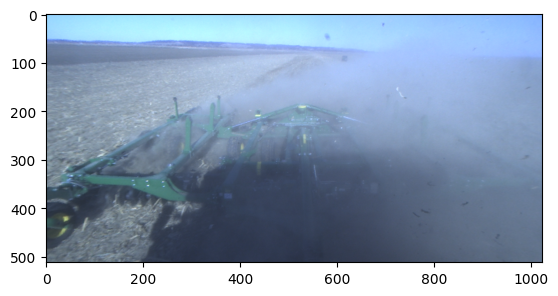

In [30]:
data_dir = os.path.join(data_root_dir, unlabeled_datasets[1])

# cam_df = seq_df[seq_df.camera_location == 'side-left-left']
cam_df = seq_df[seq_df.camera_location == 'rear-left']
print(len(seq_df), len(cam_df))

df_row = cam_df.iloc[85]
print(df_row.id, df_row.state)
img = read_from_pp_artifacts(data_dir, df_row)
plt.imshow(img)
plt.show()

In [31]:
img.dtype, img.max()

(dtype('uint8'), 255)